## Modified introduction using forex data

This is the trading rule example shown in [the introduction](https://github.com/robcarver17/pysystemtrade/blob/master/docs/introduction.md) but modified to use Interactive Brokers instead of CSV files as data source.  

IB requires a minimum equity and a monthly subscription to provide historical data on future contracts.  This example was modified to use FX prices instead futures to make it runnable with free unfunded paper trading accounts.  Note that Rob [does not recommend trading FX spot data with IB due to their high fees](https://github.com/robcarver17/pysystemtrade/issues/517#issuecomment-1010770678).

First, import the required packages and initialize ib_insync.  

In [1]:
from sysbrokers.IB.ib_connection import connectionIB
from sysbrokers.IB.ib_Fx_prices_data import ibFxPricesData

from ib_insync import util
util.startLoop() #only required when running inside a notebook

Configuring sim logging


Connecting to Interactive Brokers gateway...

In [2]:
conn = connectionIB(111)
conn

2024-06-02 10:23:52 DEBUG config {'type': 'config', 'stage': 'config'} Adding config defaults
Private configuration private/private_config.yaml does not exist; no problem if running in sim mode
2024-06-02 10:23:52 ERROR connectionIB {'type': 'connectionIB', 'broker': 'IB', 'clientid': 111} Broker account ID not found in private config - may cause issues


IB broker connection{'ipaddress': '127.0.0.1', 'port': 4001, 'client': 111}

See what fx instruments we have configured.  These are configured in `sysbrokers/IB/config/ib_config_spot_FX.csv`

In [5]:
import csv
data = {}
ibfxpricedata = ibFxPricesData(conn, data)
ibfxpricedata.get_list_of_fxcodes()

['AUDUSD',
 'CADUSD',
 'CHFUSD',
 'EURUSD',
 'GBPUSD',
 'HKDUSD',
 'JPYUSD',
 'KRWUSD',
 'CNHUSD',
 'SGDUSD',
 'MXPUSD',
 'SEKUSD']

Now we select one instrument (`EURUSD`) and try to fetch historical data for it.

In [6]:
ibfxpricedata.get_fx_prices('EURUSD')

2024-06-02 10:34:20 DEBUG ibFxPricesData {'currency_code': 'EURUSD'} Updating log attributes
2024-06-02 10:34:23 DEBUG ibFxPricesData Log attributes reset
2024-06-02 10:34:23 DEBUG ibFxPricesData {'currency_code': 'EURUSD'} Downloaded 259 prices


2024-06-02 10:34:22 DEBUG ibFxPricesData {'currency_code': 'EURUSD'} Reqid -1: 2106 HMDS data farm connection is OK:cashhmds for None


index
2023-06-02 23:00:00    1.07080
2023-06-05 23:00:00    1.07120
2023-06-06 23:00:00    1.06925
2023-06-07 23:00:00    1.06985
2023-06-08 23:00:00    1.07825
                        ...   
2024-05-27 23:00:00    1.08585
2024-05-28 23:00:00    1.08565
2024-05-29 23:00:00    1.08010
2024-05-30 23:00:00    1.08320
2024-05-31 23:00:00    1.08475
Name: FINAL, Length: 259, dtype: float64

Data can also be indexed as a python dict:

In [7]:
ibfxpricedata['JPYUSD']

2024-06-02 10:36:00 DEBUG ibFxPricesData {'currency_code': 'USDJPY'} Updating log attributes
2024-06-02 10:36:00 DEBUG ibFxPricesData Log attributes reset
2024-06-02 10:36:00 DEBUG ibFxPricesData {'currency_code': 'JPYUSD'} Downloaded 259 prices


index
2023-06-02 23:00:00    0.007149
2023-06-05 23:00:00    0.007165
2023-06-06 23:00:00    0.007161
2023-06-07 23:00:00    0.007137
2023-06-08 23:00:00    0.007198
                         ...   
2024-05-27 23:00:00    0.006374
2024-05-28 23:00:00    0.006363
2024-05-29 23:00:00    0.006343
2024-05-30 23:00:00    0.006376
2024-05-31 23:00:00    0.006357
Name: FINAL, Length: 259, dtype: float64

Create the trading rule

In [8]:
import pandas as pd
from sysquant.estimators.vol import robust_vol_calc


def calc_ewmac_forecast(price, Lfast, Lslow=None):
    """
    Calculate the ewmac trading rule forecast, given a price and EWMA speeds Lfast, Lslow and vol_lookback

    """
    if Lslow is None:
        Lslow = 4 * Lfast

    ## We don't need to calculate the decay parameter, just use the span directly
    fast_ewma = price.ewm(span=Lfast).mean()
    slow_ewma = price.ewm(span=Lslow).mean()
    raw_ewmac = fast_ewma - slow_ewma

    vol = robust_vol_calc(price.diff())

    return raw_ewmac / vol

Run a forecast with the previous rule

In [9]:
price=ibfxpricedata['EURUSD']
ewmac=calc_ewmac_forecast(price, 32, 128)
ewmac.tail(5)

2024-06-02 10:39:46 DEBUG ibFxPricesData {'currency_code': 'EURUSD'} Updating log attributes
2024-06-02 10:39:46 DEBUG ibFxPricesData Log attributes reset
2024-06-02 10:39:46 DEBUG ibFxPricesData {'currency_code': 'EURUSD'} Downloaded 259 prices


index
2024-05-27 23:00:00   -0.271630
2024-05-28 23:00:00   -0.182972
2024-05-29 23:00:00   -0.175942
2024-05-30 23:00:00   -0.129437
2024-05-31 23:00:00   -0.065137
Name: FINAL, dtype: float64

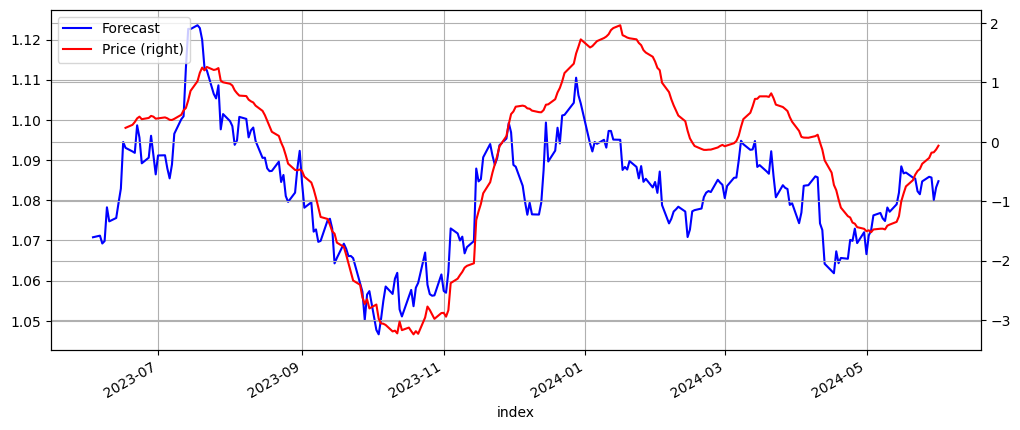

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

ax1 = price.plot(color='blue', grid=True, label='Forecast')
ax2 = ewmac.plot(color='red', grid=True, secondary_y=True, label='Price')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

The original introduction jumps directly to "Did we make any money?".  
I would like to see here the orders that were triggered by this forecast, but instead we jump directly into P&L.  Still, these are the P&L numbers for this forecast and data:

In [11]:
from systems.accounts.account_forecast import pandl_for_instrument_forecast
account = pandl_for_instrument_forecast(forecast = ewmac, price = price)
account.percent.stats()

[[('min', '-0.8347'),
  ('max', '0.6591'),
  ('median', '-0.0004984'),
  ('mean', '-0.01255'),
  ('std', '0.1453'),
  ('skew', '-0.5255'),
  ('ann_mean', '-3.212'),
  ('ann_std', '2.325'),
  ('sharpe', '-1.382'),
  ('sortino', '-1.548'),
  ('avg_drawdown', '-1.947'),
  ('time_in_drawdown', '0.9157'),
  ('calmar', '-0.7251'),
  ('avg_return_to_drawdown', '-1.65'),
  ('avg_loss', '-0.09056'),
  ('avg_gain', '0.07761'),
  ('gaintolossratio', '0.857'),
  ('profitfactor', '0.7281'),
  ('hitrate', '0.4593'),
  ('t_stat', '-1.395'),
  ('p_value', '0.1642')],
 ('You can also plot / print:',
  ['rolling_ann_std', 'drawdown', 'curve', 'percent'])]

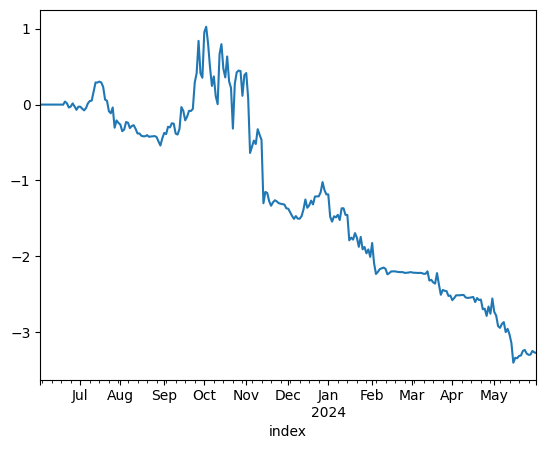

In [12]:
account.curve().plot()
plt.show()

In [13]:
conn.close_connection()

2024-06-02 10:44:45 DEBUG connectionIB {'type': 'connectionIB', 'broker': 'IB', 'clientid': 111} Terminating {'ipaddress': '127.0.0.1', 'port': 4001, 'client': 111}
